# Градиентный спуск. Имитированный отжиг

In [ ]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np

## Функционал ошибки

Среднеквадратичный функционал ошибки:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект множества данных, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса линейной модели.

Матричный вид среднеквадратичной ошибки:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Градиент среднеквадратичного функционала ошибки:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который используется для реализации всех лоссов. У него есть два абстрактных метода:
1. Метод `calc_loss`, который принимает на вход объекты `x`, правильные ответы `y` и веса `w` и вычисляет значения лосса
2. Метод `calc_grad`, который принимает на вход объекты `x`, правильные ответы `y` и веса `w` и вычисляет значения градиента в векторном виде

In [ ]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами множества данных
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами множества данных
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

**Реализация класса среднеквадратичной ошибки**

Функции данного класса вычисляют потери и градиент по формулам сверху

In [ ]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения потерь
        :param X: np.ndarray размера (n_objects, n_features) с объектами множества данных
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return np.mean((np.dot(X, w) - y) ** 2)



    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента функции потерь по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами множества данных
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return  (2 / X.shape[0]) * X.T.dot(X.dot(w) - y)

In [ ]:
# Создание объекта лосса
loss = MSELoss()
# Создание случайного множества данных
X = np.arange(200).reshape(20, 10)
y = np.arange(20)
# Создание случайного вектора весов
w = np.arange(10)
# Вывод значения функции потерь и градиента на множестве данных с данным вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))
# Проверка корректности реализации методов
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Формула для одной итерации градиентного спуска:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y),
$$

где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр шага обучения, отвечающий за его размер.

**Реализация функции градиентного спуска**

Функция принимает на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`,
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция реализует цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращается
траектория спуска (список из новых значений весов на каждом шаге)

In [ ]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = [w_init]
    for i in range(n_iterations):
        w_init = w_init - lr * loss.calc_grad(X, y, w_init)
        w.append(w_init)
    return w

Создание синтетического множества данных и функция для отрисовки траектории градиентного спуска по истории:

In [ ]:
# Создание множества данных из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [ ]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать потери при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # визуализация линий уровня
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # визуализация траектории
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Траектория градиентного спуска для разных значений длины шага**

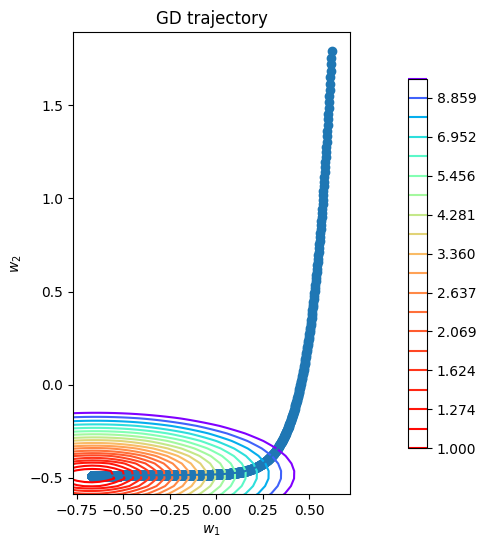

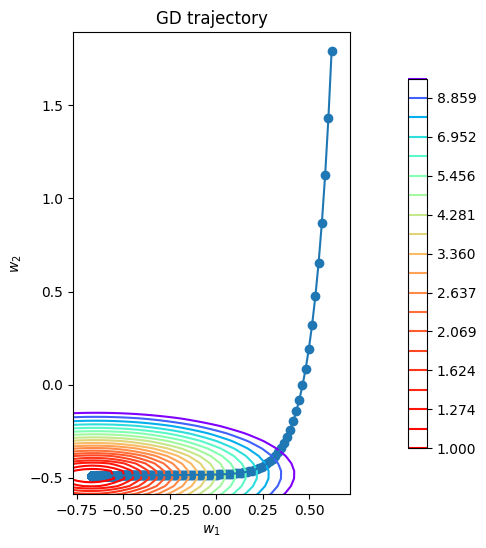

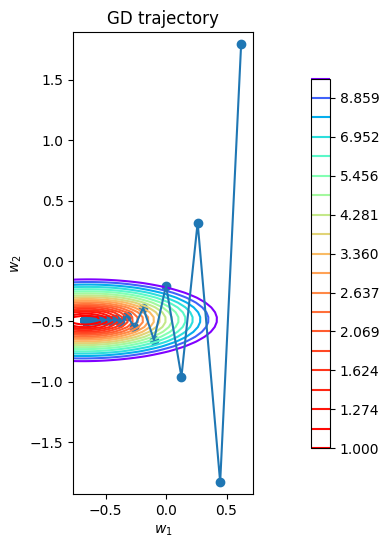

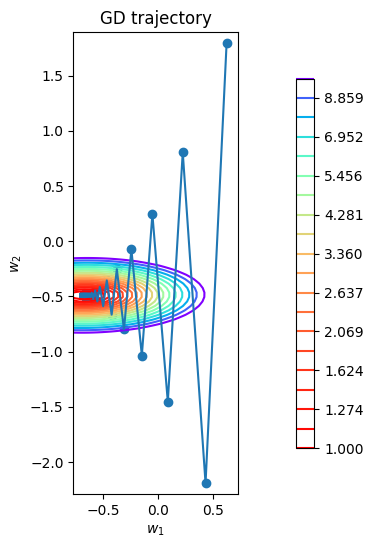

In [ ]:
for i in [0.0001, 0.001, 0.01, 0.011]:
    plot_gd(gradient_descent(w_init, X, y, loss, i), X, y, loss)

Чем больше скорость обучения (learning rate - lr), тем более резким и нестабильным становится градиентный спуск.

**Реализация функции стохастического градиентного спуска**

Функция принимает все те же параметры, что и функция градиентного спуска, но ещё параметр размера партии.

Функция как и раньше реализует цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считается градиент не по всей выборке `X`, а только по случайно выбранной части.

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]

    weights = []

    for i in range(n_iterations):
        w_init = w_init - lr * loss.calc_grad(batch, y[batch_indices], w_init)
        weights.append(w_init)
    return weights

**Траектория стохастического градиентного спуска для разных значений длины шага**

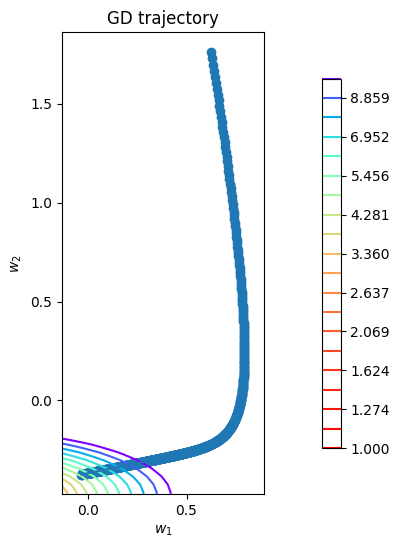

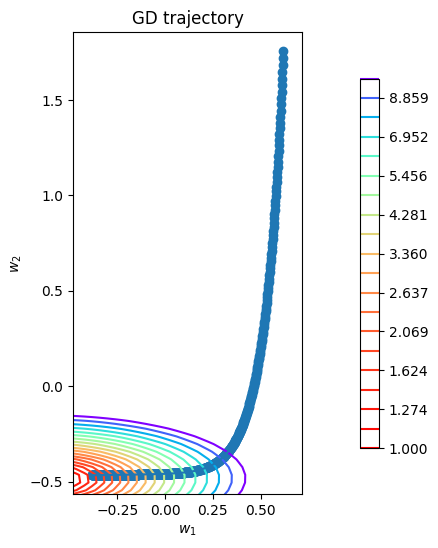

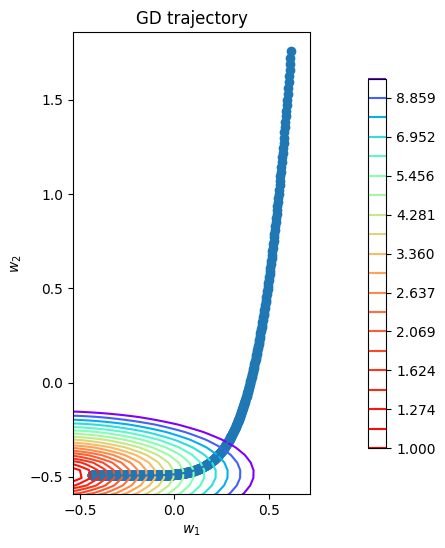

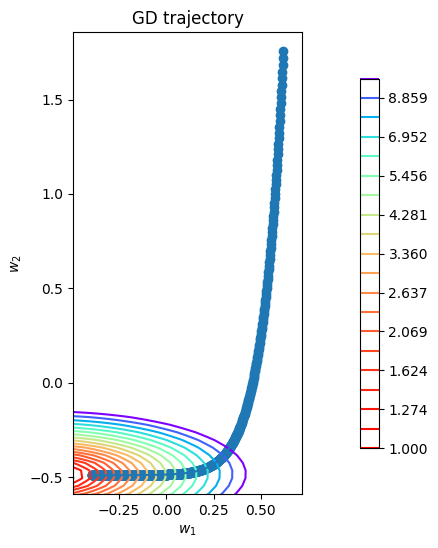

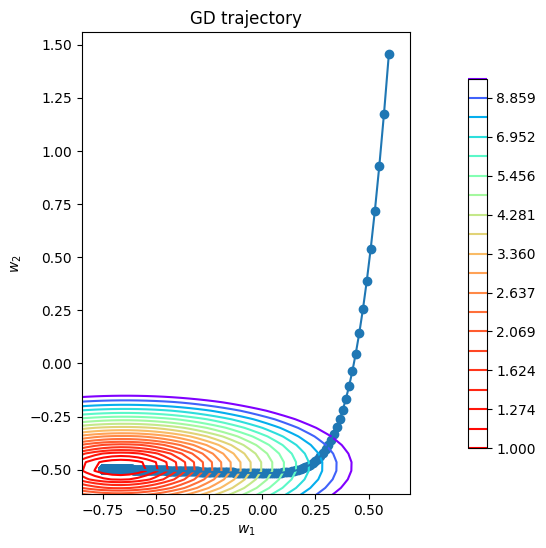

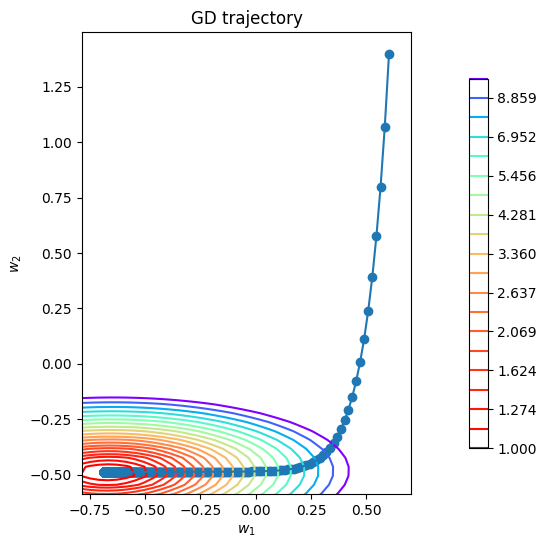

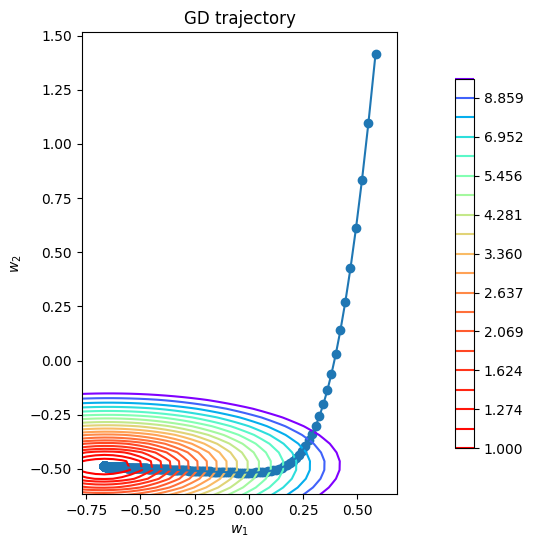

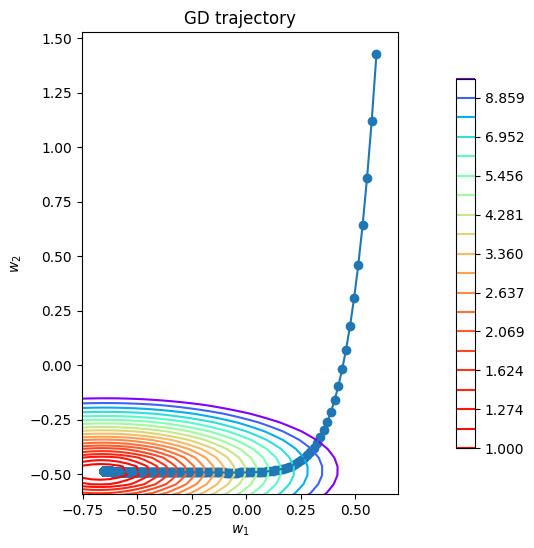

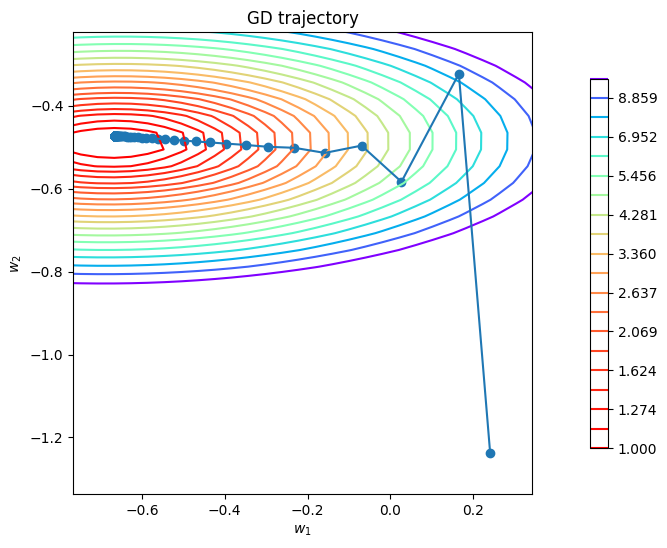

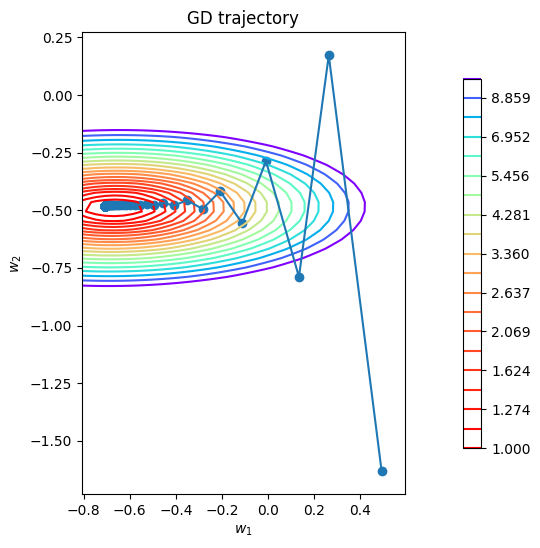

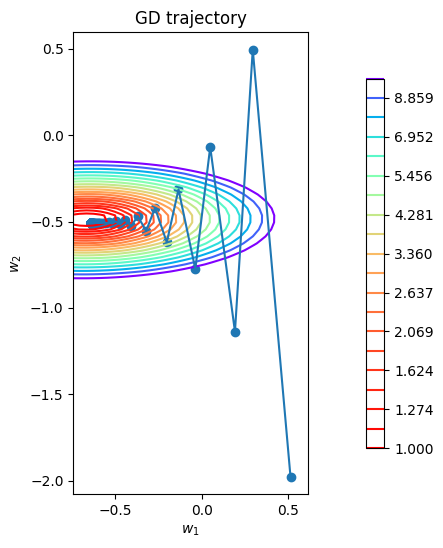

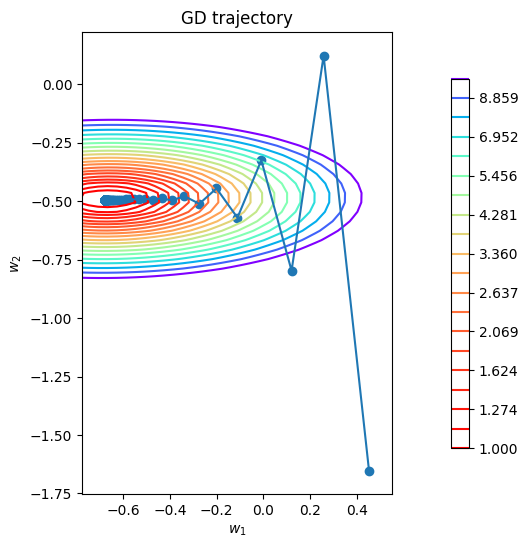

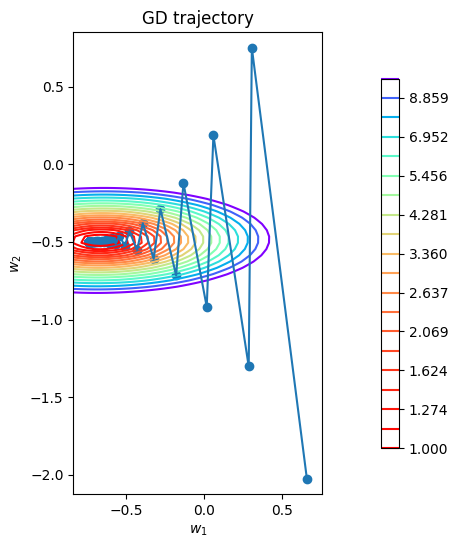

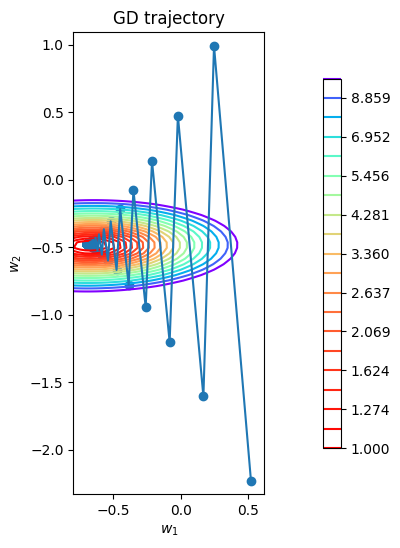

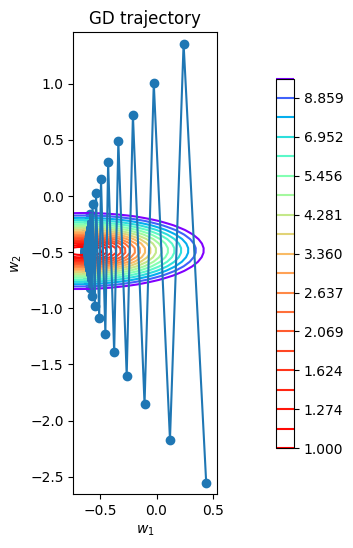

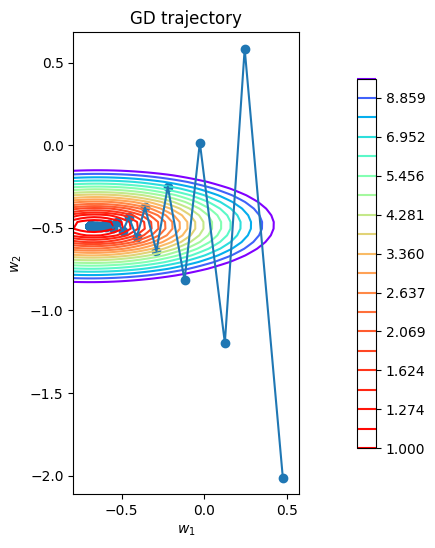

In [ ]:
for i in [0.0001, 0.001, 0.01, 0.011]:
    for j in [25, 50, 100, 200]:
        plot_gd(stochastic_gradient_descent(w_init, X, y, loss, i, j), X, y, loss)

Чем больше lr, тем более резкими становятся шаги градиентного спуска. Чем больше batch, тем более быстрым становится спуск. Кроме того, сочетание низкого lr и маленького батча приводит к недообучению (спуск не доходит до минимума).

Можно заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска необходимо делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже нужно делать маленькие шаги, чтобы точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения, стоит постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Реализация функции стохастического градиентного спуска с затухающим шагом**.

Параметр $s_0$ берется равным 1. Параметр $p$ берётся из нового аргумента функции `p`.

In [ ]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch = X[batch_indices]
    w = []
    for i in range(n_iterations):
        w_init = w_init - lr * ((1 / (1 + i)) ** p) * loss.calc_grad(batch, y[batch_indices], w_init)
        w.append(w_init)
    return w

**Траектория градиентного спуска для разных значений параметра `p`**

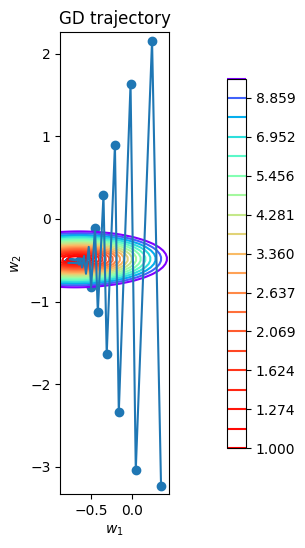

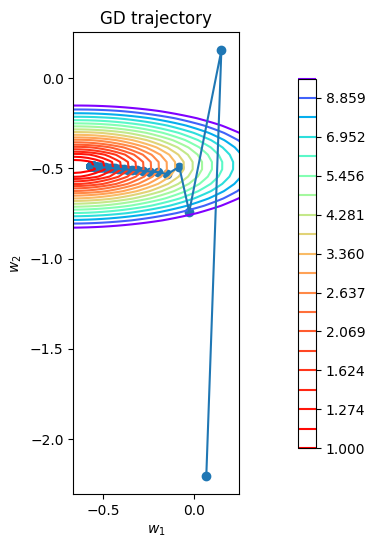

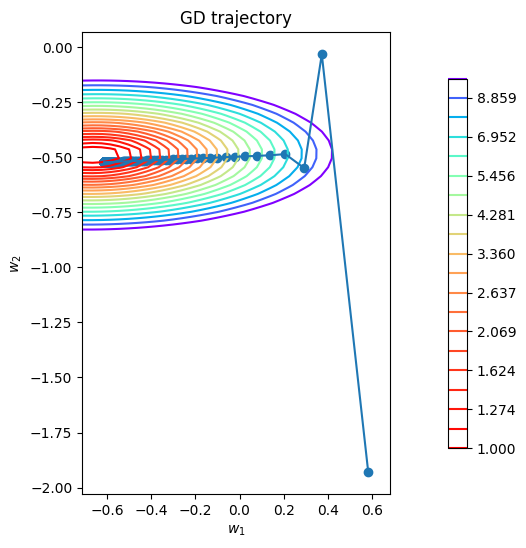

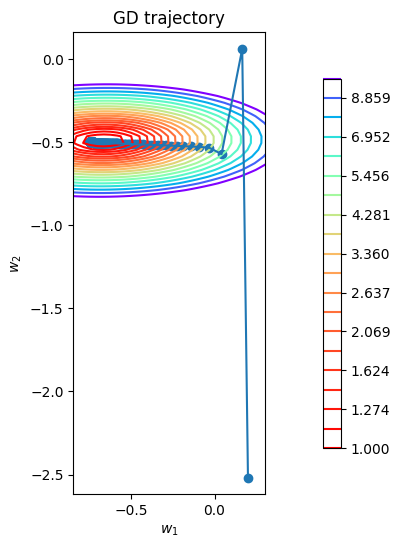

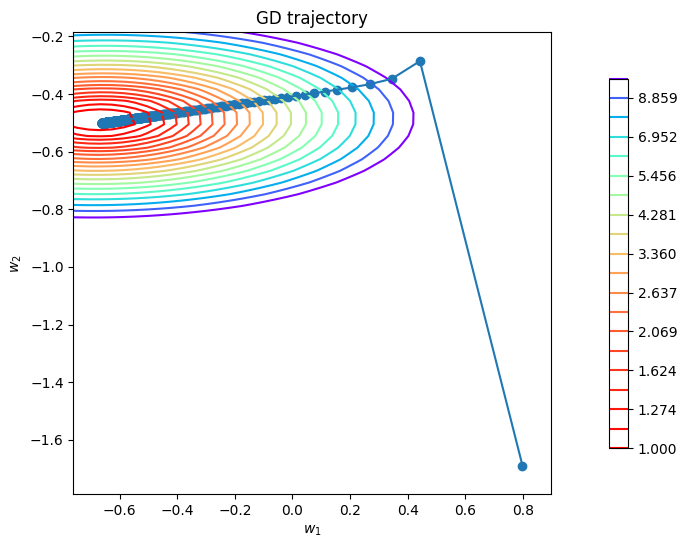

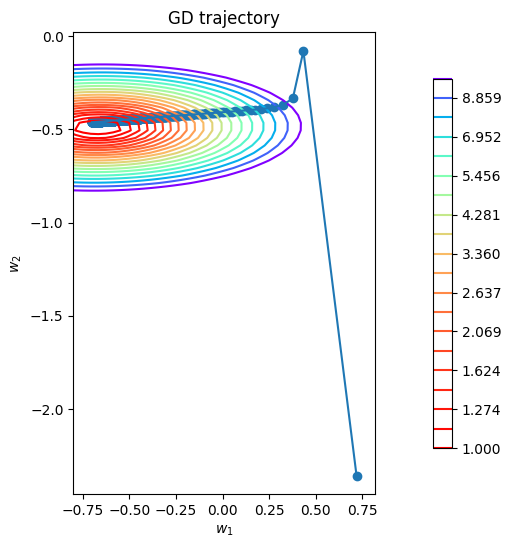

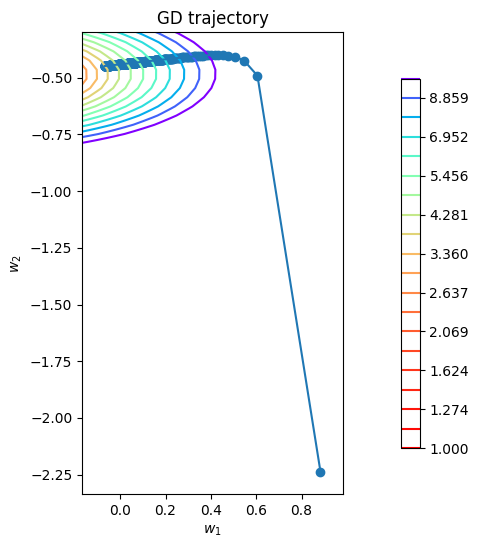

In [ ]:
for i in [0.1, 0.25, 0.33, 0.5, 0.67, 0.75, 1]:
    plot_gd(stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, i, 1000), X, y, loss)

Чем больше p, тем более стабильным становится градиентный спуск

**Сравнение сходимости обычного градиентного спуска и стохастичекой версии**

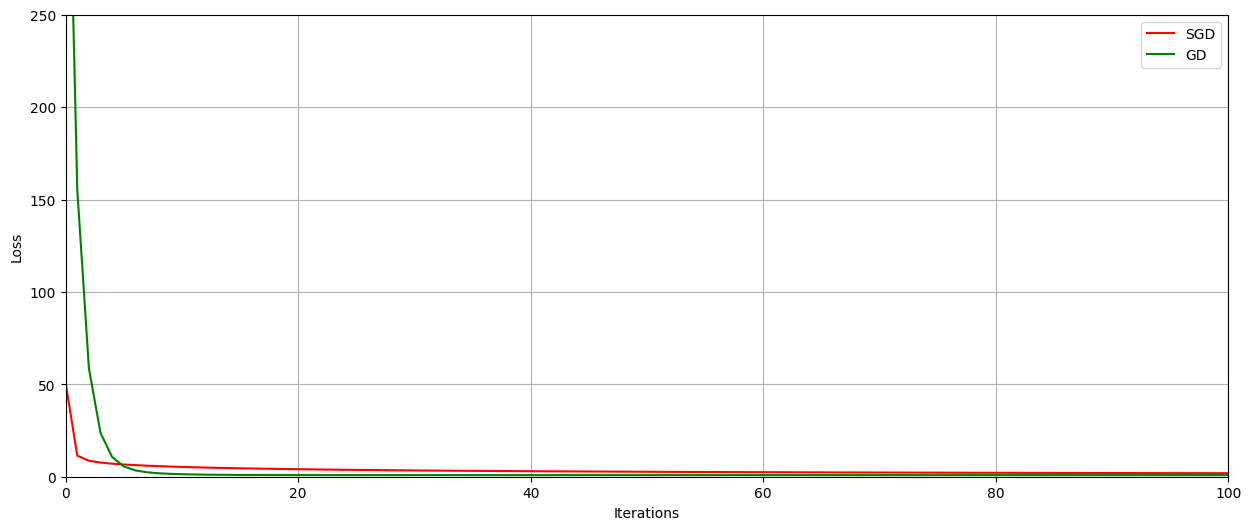

In [ ]:
weights_GD = gradient_descent(w_init, X, y, loss, 0.01)
GD = []
weights_SGD = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0.7)
SGD = []

for i in range(1000):
    SGD.append(loss.calc_loss(X, y, weights_SGD[i]))
    GD.append(loss.calc_loss(X, y, weights_GD[i]))

plt.figure(figsize=(15, 6))
plt.plot (SGD, color='r', label= 'SGD')
plt.plot(GD, color='g', label='GD')
ax = plt.gca()
ax.set_xlim([0, 100])
ax.set_ylim([0, 250])
plt.xlabel('Iterations')
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

SGD круче, поскольку он на более ранних итерациях приходит к меньшим значениям потерь

## Линейная регрессия с градиентным спуском и имитацией отжига

Класс для линейной регрессии. Он использует интерфейс библиотеки `sklearn`.

В методе `fit` подбираются веса `w` при помощи градиентного спуска методом `gradient_descent`.

В методе `predict` применяется регрессия к множеству данных

**Класс линейной регрессии**.


В методе `fit` инициализируются веса `w`, применяется градиентный спуск и сохраняется последняя `w` из траектории.

В методе `predict` вам применяется линейная регрессия и возвращается вектор ответов.

Объект функции потерь передаётся в момент инициализации и хранится в `self.loss`. Он используется в `fit` для `gradient_descent`.

In [ ]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавление столбца из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        self.w = gradient_descent(np.random.uniform(size=X.shape[1]), X, y, self.loss, self.lr)[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверка регрессии на обученность, то есть на вызов fit и установки в нем атрибута self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавление столбца из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        return np.dot(X, self.w)

Для `MSELoss` объект линейной регрессии создаётся так:

In [ ]:
linear_regression = LinearRegression(MSELoss())

Загрузка множества данных с машинами

In [ ]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [ ]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

**Обработка множества данных**
* Разделение множества данных на обучающую и тестовую выборку
* Заполнение пропусков
* Нормализация числовых признаков
* Кодировка категориальных переменных

In [ ]:
import warnings

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_raw.columns = X_raw.columns.astype(str)
# создание маски, указывающей на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values

# заполнение пропусков средними для вещественнозначных признаков
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(
    data=mis_replacer.fit_transform(X_real), columns=X_real.columns
)

# для категориальных — пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

In [ ]:
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(f"Data shape: {X_dum.shape}")
X_dum.head()

Data shape: (201, 66)


,index,0,1,9,10,11,12,13,16,18,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,0.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,False,False,False,False,False,False,False,True,False,False
1,1.0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,...,False,False,False,False,False,False,False,True,False,False
2,2.0,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,...,False,False,False,False,False,False,False,True,False,False
3,3.0,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,...,False,False,False,False,False,False,False,True,False,False
4,4.0,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
X_dum.columns = X_dum.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.33, random_state=42)

In [ ]:
normalizer = MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

**Обучение линейной регрессии**

In [ ]:
lr = linear_regression.fit(X_train, y_train)

**Расчёт ошибки обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.**

In [ ]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_train, lr.predict(X_train)), mean_squared_error(y_test, lr.predict(X_test)), sep='\n')

1284112.9545845576
9584326.812212702


Данная модель переобучена. Необходимо добавить L2 регуляризацию.

Формула функции потерь для MSE с L2 регуляризацией:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

В матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2,
$$

где $\lambda$ — коэффициент регуляризации

Градиент:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Реализация класса `MSEL2Loss`**

Последний элемент вектора `w` — это смещение (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Смещение не регуляризуется. Соответственно последний элемент из `w` удаляется при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и зануляется при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами множества данных. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # Вычисление значения функции потерь при помощи X, y и w и его возврат
        return np.mean((np.dot(X, w) - y) ** 2) + self.coef * np.mean(w[:-1] ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами множества данных
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # Вычисление значения вектора градиента при помощи X, y и w и его возврат
        return (2 / X.shape[0]) * X.T.dot(X.dot(w) - y) + 2 * self.coef * np.append(w[:-1], 0)

Регрессия с L2 регуляризацией

In [ ]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Обучение регрессии с функцией потерь `MSEL2Loss`**.

Подбор коэффициента регуляризации и улучшение результатов на тестовой выборке. Сравнение результатов на обучающей и тестовой выборке с регрессией без регуляризации.

In [ ]:
for i in [0, 0.0001, 0.00076, 0.001, 0.0011]:
    linear_regression = LinearRegression(MSEL2Loss(i))
    linear_regression.fit(X_train, y_train)
    print(mean_squared_error(y_train, linear_regression.predict(X_train)), mean_squared_error(y_test, linear_regression.predict(X_test)), sep='\n')
    print()

1284113.301460765
9584247.285436241

1367571.905650257
7364639.257286161

1701671.2511530027
5871957.673955853

1783521.7511703477
5907879.428631629

1814563.0462343409
5936232.80161515



Было проведено очень много тестов различных коэффициентов регуляризации. Самым лучшим оказался 0.00076. Благодаря нему удалось добиться значительного снижения ошибки на тестовой выборке при небольшом увеличении ошибки на тренировочной выборке.

В множестве данных могут быть выбросы. С выбросами помогает бороться Huber Loss. Вдали от нуля он работает как средняя абсолютная ошибка и не реагирует на выбросы так сильно, как функция среднеквадратичной ошибки.

Функция потерь Huber Loss:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


Градиент:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Реализация класса `HuberLoss`**.

Вычисление потерь и градиента по формулам сверху

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # Вычисление значения функции потерь при помощи X, y и w и его возврат
        return np.mean(np.where(np.abs(X.dot(w) - y) < self.eps, 0.5 * (X.dot(w) - y) ** 2, self.eps * (abs(X.dot(w) - y) - 0.5 * self.eps)))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # Вычисление значения вектора градиента при помощи X, y и w и его возврат
        return np.mean(X * (np.where(np.abs(X.dot(w) - y) < self.eps, (X.dot(w) - y), (self.eps * np.sign(X.dot(w) - y))))[:, None], axis=0)

**Обучение регрессии с функцией потерь `HuberLoss`**.

Сравнение результатов на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [ ]:
for i in [485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495]:
    huber_lr = LinearRegression(HuberLoss(i))
    lr = huber_lr.fit(X_train, y_train)
    print(mean_squared_error(y_train, huber_lr.predict(X_train)), mean_squared_error(y_test, huber_lr.predict(X_test)), sep='\n')
    print()

1997218.5051528458
6010718.569982471

1996255.1671022694
6010597.505469275

1995281.0405210764
6010601.430038391

1994319.9110444402
6010534.129642508

1993361.1799839344
6010559.981183812

1992415.6509976867
6010541.027519929

1991466.4230987353
6010471.0404715175

1990511.6859471824
6010545.067670289

1989572.656555818
6010511.093629882

1988621.528276898
6010543.589275323

1987697.74688178
6010729.026397156



Проведено много тестов, лучший результат оказался у эпсилон 495, однако ошибка и на тренировочной, и на тестовой выборке выше, чем у MSELoss, на 150000 в среднем.

### Имитированный отжиг

Градиентный спуск — далеко не единственный метод оптимизации.
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения.

**Алгоритм имитации отжига для оптимизации функции среднеквадратичной ошибки линейной регрессии**.

Сравнение результатов с градиентным спуском по "траектории" и по финальному объёму потерь.

Каждая новая точка (веса регресси в данном случае) семплируется из некоторого случайного распределением с центром в текущей точке. Подходят распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3. Чем больше параметр распределения, тем реже новые точки будут очень сильно уходить от старых.

In [ ]:
def simulated_annealing(X, y, w_init, temperature=1.0, cooling_rate=0.9, n_student=3, n_iterations=100000):
    old_w = w_init
    best_w = w_init
    best_loss = loss.calc_loss(X, y, w_init)
    weights = []


    for i in range(n_iterations):
        new_w = old_w + np.random.standard_t(n_student, size=old_w.shape)
        new_loss = loss.calc_loss(X, y, new_w)

        if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):
            old_w = new_w
            best_w = new_w
            best_loss = new_loss

        temperature *= cooling_rate
        weights.append(best_w)
    return weights

In [ ]:
for i in [2, 3, 4]:
    print(mean_squared_error(y_train, X_train.dot(simulated_annealing(X_train, y_train, np.random.standard_t(i, size=X_train.shape[1]), n_student=i)[-1])), mean_squared_error(y_test, X_test.dot(simulated_annealing(X_train, y_train, np.random.standard_t(i, size=X_train.shape[1]), n_student=i)[-1])), sep='\n')

/tmp/ipython-input-31-990252769.py:12: RuntimeWarning: overflow encountered in scalar divide
  if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):
/tmp/ipython-input-31-990252769.py:12: RuntimeWarning: overflow encountered in scalar divide
  if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):


1517428.215432346
6124645.02258677


/tmp/ipython-input-31-990252769.py:12: RuntimeWarning: overflow encountered in scalar divide
  if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):
/tmp/ipython-input-31-990252769.py:12: RuntimeWarning: overflow encountered in scalar divide
  if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):


1625792.7687471597
5875862.7017690325


/tmp/ipython-input-31-990252769.py:12: RuntimeWarning: overflow encountered in scalar divide
  if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):
/tmp/ipython-input-31-990252769.py:12: RuntimeWarning: overflow encountered in scalar divide
  if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):


1714502.317891255
5884719.0611175755


Параметр 3 распределения Стьюдента всё же оптимален. Имитация отжига бьет не только MSELoss и HuberLoss, но и MSEL2Loss - предыдущего рекордсмена. Ошибка и на тренировочной выборке, и, что более важно, на тестовой выборке немного, но ниже.

Снова инициализируем случайные веса для прорисовки двухвесового похода до минимума.

In [ ]:
# Создание множества данных из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


/tmp/ipython-input-31-990252769.py:12: RuntimeWarning: overflow encountered in scalar divide
  if new_loss < best_loss or np.random.uniform(0, 1) < np.exp((best_loss - new_loss) / temperature):


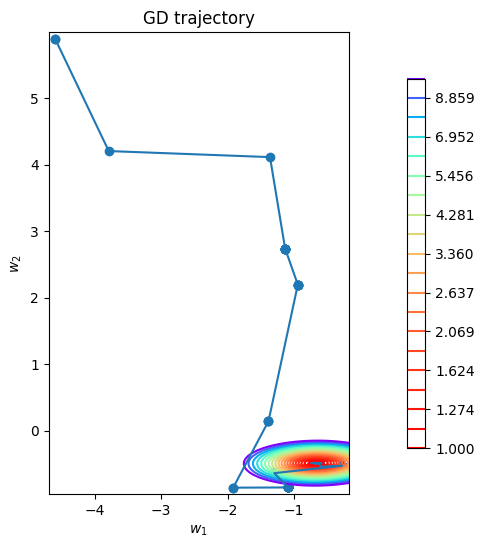

In [ ]:
plot_gd(simulated_annealing(X, y, np.random.standard_t(3, size=X.shape[1])), X, y, loss)

Имитация отжига идёт более непредсказуемыми для невооруженного глаза шагами, чем градиентный спуск. Однако отжиг работает значительно быстрее, чем спуск.